### Imports

In [109]:
import os
import numpy as np
import pandas as pd
import importlib
import re

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

# Dictionaries: species_name to ba and vice versa
species_id_to_name = descriptions.species_id_to_name()
species_name_to_id = descriptions.species_name_to_id()

### Definitions

In [110]:
# Directory: Processed tnr%.hdf5s
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

# Directory: Plots
dir_plots = r"C:\Data\lwf\analysis\220825_color-ratios\plots"

### Load crowns' features of all hdf5s
* As pandas.DataFrame

In [111]:
importlib.reload(io)

df, params_df = io.allhdf5s_crowns_features_to_dataframe(dir_hdf5, crowns_type='crowns_human')

# Replace inf values with nans
df = df.where(df != np.inf, np.nan)

### Assign families to crowns

In [115]:
importlib.reload(descriptions)

# Define families by patterns
family_patterns = [
    'kiefer',
    'fichte',
    'buche',
    'eiche',
]

families = descriptions.species_groupby_families(family_patterns)
family_ids = descriptions.species_id_to_family_id(df.ba.values, families)

df = df.assign(
    family = family_ids,
    )

### Infos

#### Search: Pattern in column names

In [ ]:
pattern = 'min'

cols = list(df.columns)
for col in cols:
    if bool(re.search(pattern, col, re.IGNORECASE)):
        print(col)

#### Info: Dataset

In [117]:
importlib.reload(descriptions)

descriptions.print_summary(
    df.tnr.values,
    df.ba.values,
    df.family.values,
    families,
)

Total number of crowns        : 3895
Mean number of crowns per tnr : 30.9
__________________________________________________

species_id| species_name                  | count
--------------------------------------------------
       134| Gemeine Kiefer                : 1544
       118| Gemeine Fichte                : 945
        20| Rotbuche                      : 448
       100| Weißtanne                     : 207
        48| Traubeneiche                  : 203
       116| Europäische Lärche            : 117
        51| Stieleiche                    : 93
        10| Gemeine Birke                 : 44
        22| Gemeine Esche                 : 43
         7| Schwarzerle                   : 38
        13| Hainbuche                     : 34
       136| Douglasie                     : 33
         5| Bergahorn                     : 23
       129| Schwarzkiefer                 : 16
        36| Kirsche                       : 15
         1| Feldahorn                     : 14
        68| Wi

### Plotting

#### Query & groupby

In [139]:
############## Define queries
query_all = 'kkl in [1, 2, 3]'
query_all += ' and equivalent_diameter_area > 1'
query_all += ' and min_bright_ndre > 0'
query_all += ' and eccentricity > 0'
query_all += ' and eccentricity < 1'


############### Column
cols = [
    'family', 'sst',
    'median_bright_blue',
    'median_bright_green',
    'median_bright_red',
    'median_bright_re',
    'median_bright_nir',
    'median_bright_gob',
    'median_bright_rob',
    'median_bright_reob',
    'median_bright_nob',
]

############### Groupby
df_grouped = df.query(query_all).loc[:, cols].groupby(['family', 'sst']).describe()

#### Plot: Color (absolute) intensities

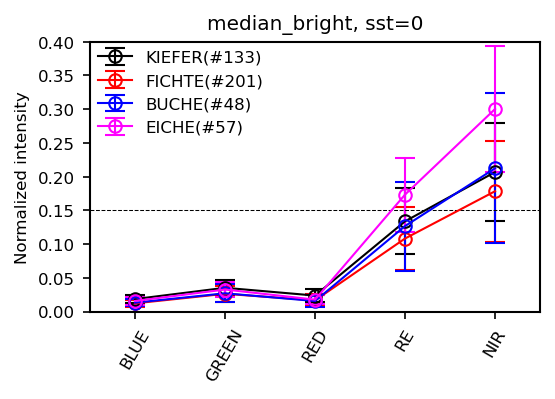

In [162]:
############### Plotting specs
feature_prename = 'median_bright_'
channels = ['blue', 'green', 'red', 're', 'nir']
sst = 0
statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']
save_name = 'abs_' + feature_prename + f"sst{sst}"+ '.svg'

ylim = [0,0.4]

cols = [feature_prename + name for name in channels] 

############### Plotting
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.8)
ax = f.add_subplot(111)


for i, (family_id, family) in enumerate(families.items()):

    try:
        # y-data: Definition
        y = df_grouped.loc[(family_id, sst), (cols, statistics)].values
        yerr = df_grouped.loc[(family_id, sst), (cols, statistics_err)].values

        # y-data: Remove NaNs in case of single crown per family
        y = y[np.isfinite(yerr)]
        yerr = yerr[np.isfinite(yerr)]

        # x-data & counts
        x = range(len(y))
        counts = df_grouped.loc[(family_id, sst), (cols[0], 'count')]

        if counts > 1:
            ax.errorbar(
                x,
                y,
                yerr,
                label=family['family_name'].upper() + f"(#{counts:.0f})",
                marker='o',
                c=colors[i],
                mec=colors[i],
                mfc='none',
                ms=6,
                capsize=5,
            )
    except:
        pass

ax.legend(loc='upper left')
ax.set_title(f"{feature_prename[:-1]}, sst={sst}")

ax.axhline(0.15,ls='--',lw=0.5,c='k')

ax.set_xlim([-.5, 4.5])
ax.set_xticks(range(5))
ax.set_xticklabels(['BLUE', 'GREEN', 'RED', 'RE', 'NIR'], rotation=60)

ax.set_ylim(ylim)
ax.set_ylabel('Normalized intensity')

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

#### Plot: Color ratios

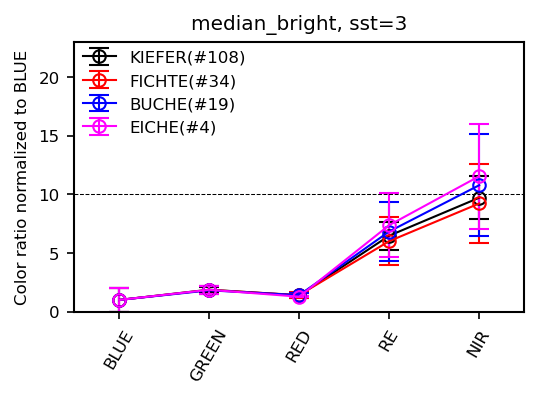

In [157]:
############### Plotting specs
feature_prename = 'median_bright_'
channels = ['gob', 'rob', 'reob', 'nob']
sst = 3
statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']
save_name = feature_prename + f"sst{sst}"+ '.svg'

ylim = [0,23]

cols = [feature_prename + name for name in channels] 

############### Plotting
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.8)
ax = f.add_subplot(111)


for i, (family_id, family) in enumerate(families.items()):

    try:
        y = np.ones(5)
        yerr = np.ones(5)

        # y-data: Definition
        y[1:] = df_grouped.loc[(family_id, sst), (cols, statistics)].values
        yerr[1:] = df_grouped.loc[(family_id, sst), (cols, statistics_err)].values

        # y-data: Remove NaNs in case of single crown per family
        y = y[np.isfinite(yerr)]
        yerr = yerr[np.isfinite(yerr)]

        # x-data & counts
        x = range(len(y))
        counts = df_grouped.loc[(family_id, sst), (cols[0], 'count')]

        if counts > 1:
            ax.errorbar(
                x,
                y,
                yerr,
                label=family['family_name'].upper() + f"(#{counts:.0f})",
                marker='o',
                c=colors[i],
                mec=colors[i],
                mfc='none',
                ms=6,
                capsize=5,
            )
    except:
        pass

ax.legend(loc='upper left')
ax.set_title(f"{feature_prename[:-1]}, sst={sst}")

ax.axhline(10,ls='--',lw=0.5,c='k')

ax.set_xlim([-.5, 4.5])
ax.set_xticks(range(5))
ax.set_xticklabels(['BLUE', 'GREEN', 'RED', 'RE', 'NIR'], rotation=60)

ax.set_ylim(ylim)
ax.set_ylabel('Color ratio normalized to BLUE')

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)